Analysing the weather using netcdf and basemap
=============================================

Using [netcdf4-python](http://netcdf4-python.googlecode.com) to read some [NOMADS](http://nomads.ncep.noaa.gov/txt_descriptions/NOMADS_doc.shtml) [openDAP](http://opendap.org) ensemble forecast data, use [numpy](http://numpy.org) to do some rudimentary analysis, and have [matplotlib](http://matplotlib.org) and [Basemap](http://matplotlib.org/basemap) plot the results. 

In [1]:
%matplotlib inline

In [2]:
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import cm as basemapcm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset, num2date  # netcdf4-python module
from datetime import datetime, timedelta

# Import widgets for interactive notebook
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


First we need to determine the correct forecast time to be retrieving. The global ensemble forecast output is published generally around 6 hours following the initial time, so we need to work backwards from the present UTC time. 

In [3]:
def get_forecast_time(delay=6):
    now = datetime.utcnow()
    print "Current time: {0}".format(now)
    fcast_time = datetime.utcnow()
    if now.hour < delay:
        fcast_time = fcast_time - timedelta(1)
        fcast_time = fcast_time.replace(hour=delay+6, minute=0)
    elif (now.hour >=delay and now.hour < (delay+12)):
        fcast_time = fcast_time.replace(hour=0)
    elif now.hour >= (delay+12):
        fcast_time = fcast_time.replace(hour=12)
    print "Forecast time: {0}".format(fcast_time)
    return fcast_time

Open an a [NOMADS](http://nomads.ncep.noaa.gov/txt_descriptions/NOMADS_doc.shtml) dataset containing NOAA/NCEP global ensemble forecast output with the netcdf4-python module.  Only the last week of forecasts are kept online, so you'll probably have to change the date in this URL to make it work.  

In [4]:
fcast_time = get_forecast_time()
fcast_date_string = fcast_time.strftime("gens%Y%m%d/gep_all_%Hz")
data_url = 'http://nomads.ncep.noaa.gov:80/dods/gens/{0}'.format(fcast_date_string)
print "Dataset URL: " +  data_url

Current time: 2015-04-14 02:39:36.582000
Forecast time: 2015-04-13 12:00:36.582000
Dataset URL: http://nomads.ncep.noaa.gov:80/dods/gens/gens20150413/gep_all_12z


In [5]:
gfs_fcst = Dataset(data_url)
print ""
print "Dataset description:"
print gfs_fcst


Dataset description:
<type 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC file format):
    title: GENS all members fcst starting from 12Z13apr2015, downloaded Apr 13 17:48 UTC
    Conventions: COARDS
GrADS
    dataType: Grid
    history: Mon Apr 13 18:16:33 GMT 2015 : imported by GrADS Data Server 2.0
    dimensions: ens, lat, lev, lon, time
    variables: ens, time, lev, lat, lon, absvprs, no4lftxsfc, no5wava500mb, no5wavh500mb, acpcpsfc, albdosfc, apcpsfc, capesfc, cape180_0mb, cfrzrsfc, cicepsfc, cinsfc, cin180_0mb, clwmrprs, cpratsfc, crainsfc, csnowsfc, cwatclm, cworkclm, dlwrfsfc, dpt2m, dswrfsfc, gfluxsfc, gpa1000mb, gpa500mb, hgtsfc, hgtprs, hgt2pv, hgtneg2pv, hgttop0c, hgt0c, hgtmwl, hgttrop, hpblsfc, icecsfc, landsfc, lftxsfc, lhtflsfc, o3mrprs, pevprsfc, potsig995, pratesfc, preslclb, preslclt, presmclb, presmclt, preshclb, preshclt, pressfc, pres2pv, presneg2pv, prescclb, prescclt, presmwl, prestrop, prmslmsl, pvort320k, pwatclm, rhprs, rh2m, rhsg330_1000, rhsg440_1000, r

Get the available forecast times and convert to [datetime](http://docs.python.org/2/library/datetime.html) instances.

In [7]:
time = gfs_fcst.variables['time']

print time
print "Units: " + time.units
valid_dates = num2date(time[:], time.units).tolist()
timelist = [d.strftime('%Y-%m-%d %H:%M') for d in valid_dates]
print "\nValid times:"
print timelist
levels = gfs_fcst.variables['lev']
print "\nLevels:"
print [level for level in levels[:]]

<type 'netCDF4.Variable'>
float64 time(time)
    grads_dim: t
    grads_mapping: linear
    grads_size: 65
    grads_min: 12z13apr2015
    grads_step: 6hr
    units: days since 1-1-1 00:00:0.0
    long_name: time
    minimum: 12z13apr2015
    maximum: 12z29apr2015
    resolution: 0.25
unlimited dimensions: 
current shape = (65,)

Units: days since 1-1-1 00:00:0.0

Valid times:
['2015-04-13 12:00', '2015-04-13 18:00', '2015-04-14 00:00', '2015-04-14 06:00', '2015-04-14 12:00', '2015-04-14 18:00', '2015-04-15 00:00', '2015-04-15 06:00', '2015-04-15 12:00', '2015-04-15 18:00', '2015-04-16 00:00', '2015-04-16 06:00', '2015-04-16 12:00', '2015-04-16 18:00', '2015-04-17 00:00', '2015-04-17 06:00', '2015-04-17 12:00', '2015-04-17 18:00', '2015-04-18 00:00', '2015-04-18 06:00', '2015-04-18 12:00', '2015-04-18 18:00', '2015-04-19 00:00', '2015-04-19 06:00', '2015-04-19 12:00', '2015-04-19 18:00', '2015-04-20 00:00', '2015-04-20 06:00', '2015-04-20 12:00', '2015-04-20 18:00', '2015-04-21 00:00',

Plot the ensemble mean on a basemap covering Australia.

In [8]:
def plot_mean(timestamp, threshold=5.):
    idx = timelist.index(timestamp)
    apcpens = gfs_fcst.variables['apcpsfc'][:,idx,:,:]
    prmslens = gfs_fcst.variables['prmslmsl'][:,idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][:,idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][:,idx,12,:,:]
    thkens = (hgt500 - hgt1000)/10.
    apcp = apcpens.mean(axis=0)
    prmsl = prmslens.mean(axis=0)
    thk = thkens.mean(axis=0)

    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats)
    fig = plt.figure(figsize=(18,12))
    gs = gridspec.GridSpec(3,4)
    
    ax1 = plt.subplot(gs[0:2,:])
    ax2 = plt.subplot(gs[-1,0:2])
    ax3 = plt.subplot(gs[-1,3:-1])
    m = Basemap(ax=ax1,projection='mill',llcrnrlon=80., llcrnrlat=-45, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x,y = m(lons, lats) # convert lats/lons to map projection coordinates
    clevs = [0,.1,.25,.5,.75,1.0,1.5,2.0,3.0,4.0,5.0,7.0,10.0,15.0,20.0,25.0,30.0,40.0,50.0,60.0,75.0]

    cs = m.contourf(x,y,apcp,clevs,cmap=basemapcm.s3pcpn,extend='max')  # color-filled contours
    ct = m.contour(x,y,thk, np.arange(500, 600, 4), colors='0.75', linestyle='--')
    cp = m.contour(x,y,prmsl/100.,np.arange(900, 1040, 2), colors='k')
    cb = m.colorbar(cs,extend='max')  # draw colorbar
    parallels = m.drawparallels(np.arange(-50,0,10),labels=[1,0,0,0])  # draw parallels, label on left
    meridians = m.drawmeridians(np.arange(80,190,10),labels=[0,0,0,1]) # label meridians on bottom
    
    fig.suptitle('ens mean apcp fcst from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')
    
    rainprob = 100.*((apcpens > threshold ).sum(axis=0))/apcpens.shape[0]
    m1 = Basemap(ax=ax2,projection='mill',llcrnrlon=80., llcrnrlat=-45, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    m1.drawcoastlines(color='r')
    
    cs1 = m1.contourf(x,y,rainprob,np.linspace(0,100.,41),cmap=basemapcm.GMT_haxby_r)
    m1.drawstates()
    cb1 = m1.colorbar(cs1)
    
    t = ax2.set_title('ens prob apcpsfc > {0} mm'.format(threshold), fontsize='small')
    
    m2 = Basemap(ax=ax3,projection='mill',llcrnrlon=80., llcrnrlat=-45, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    rainsd = np.std(apcpens, axis=0)
    m2.drawcoastlines(color='r')
    cs2 = m2.contourf(x,y,rainsd,np.linspace(0,10.,41),cmap=basemapcm.GMT_haxby_r,extend='max')
    m2.drawstates()
    cb2 = m2.colorbar(cs2,extend='max')
   
    t = ax3.set_title('Ensemble S.D.', fontsize='small')
    #fig.tight_layout(h_pad=0.02, w_pad=0.02)

What's the probability of more than 5 mm of rain in the forecast period (accumulated in the 6 hours preceding the selected time)? 

There's a wide range of outcomes among the ensemble members. To visualise this, we plot the standard deviation of the accumulated precipitation field across the ensemble members. 

In [ ]:
interact(plot_mean, timestamp=widgets.Dropdown(options=timelist, value=timelist[0]),
         threshold=(0.0,20.0, 1.0))

Ensemble weather prediction systems run multiple versions of the same model, each with slightly varying initial conditions. In this case, the NCEP Ensemble Prediction System runs 20 members. As time evolves, the solutions diverge. We plot every ensemble member to get an idea of the forecast uncertainty using the matplotlib.pyplot subplot function.

In [28]:
def plot_ensemble(timestamp):
    
    idx = timelist.index(timestamp)
    apcpens = gfs_fcst.variables['apcpsfc'][:,idx,:,:] #- 273.15
    prmslens = gfs_fcst.variables['prmslmsl'][:,idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][:,idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][:,idx,12,:,:]
    thkens = (hgt500 - hgt1000)/10.
    apcp = apcpens.mean(axis=0)
    prmsl = prmslens.mean(axis=0)
    thk = thkens.mean(axis=0)

    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats) 
    clevs = [0,.1,.25,.5,.75,1.0,1.5,2.0,3.0,4.0,5.0,7.0,10.0,15.0,20.0,25.0,30.0,40.0,50.0,60.0,75.0]
    m = Basemap(projection='mill',llcrnrlon=80., llcrnrlat=-45, urcrnrlon=180., urcrnrlat=0.,resolution='i')
    x,y = m(lons, lats)
    fig = plt.figure(figsize=(20,16))
    for nens in range(1,21):
        ax = plt.subplot(5,4,nens)
        m.drawcoastlines()
        cs = m.contourf(x,y,apcpens[nens],clevs,cmap=basemapcm.s3pcpn)
        ct = m.contour(x,y, thkens[nens],np.arange(500, 600, 4), colors='0.75', linestyle=':')
        cp = m.contour(x,y,prmslens[nens]/100.,np.arange(900, 1040, 2),colors='k')
        t = plt.title('Member %s' % nens)
    
    fig.suptitle('Ensemble apcp forecast from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')
    plt.tight_layout()
    

Plot each of the ensemble members to highligt the subtle differences between each member. Earlier in the forecast period, there's likely to be little difference between them, but towards the end of the period, we would expect to see larger differences as the solutions all diverge based on the slightly different initial conditions. 

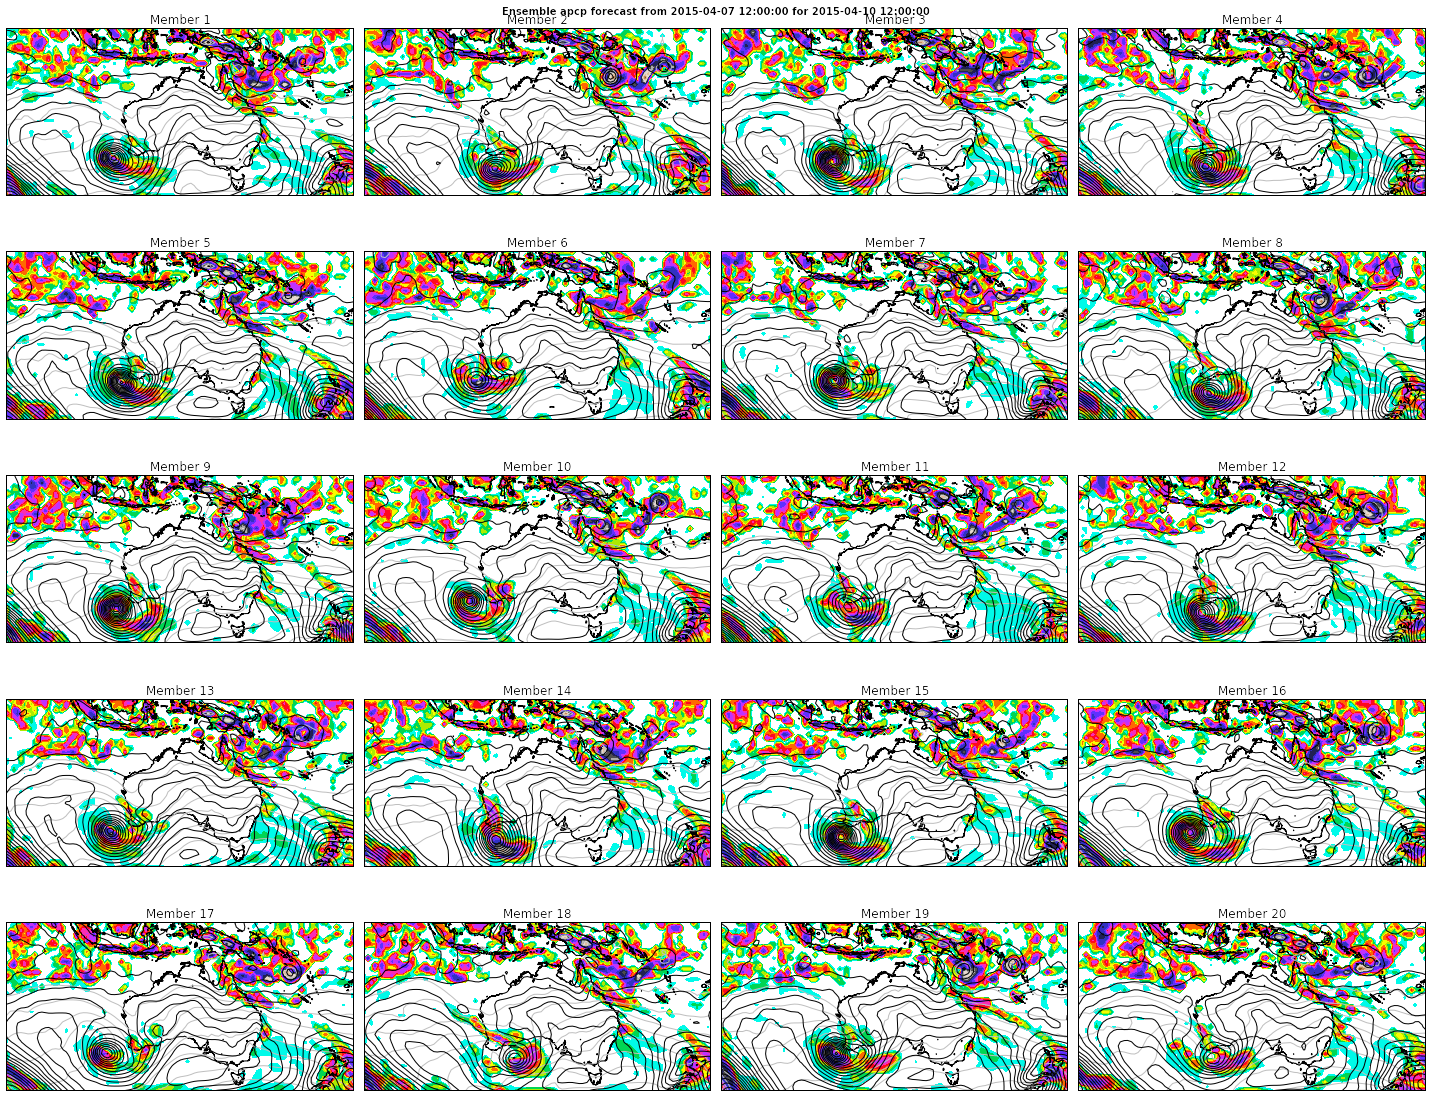

In [29]:
interact(plot_ensemble, timestamp=widgets.DropdownWidget(options=timelist, value=timelist[1]))

In [9]:
def plot_mean_wind(timestamp, threshold=15.):
    idx = valid_dates.index(timestamp)
    uu = gfs_fcst.variables['ugrdsig995'][:,idx,:,:]
    vv = gfs_fcst.variables['vgrdsig995'][:,idx,:,:]
    wspd = np.sqrt(uu*uu + vv*vv)
    prmslens = gfs_fcst.variables['prmslmsl'][:,idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][:,idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][:,idx,12,:,:]
    thkens = (hgt500 - hgt1000)/10.
    wspdmean = wspd.mean(axis=0)
    prmsl = prmslens.mean(axis=0)
    thk = thkens.mean(axis=0)

    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats)
    fig = plt.figure(figsize=(18,12))
    gs = gridspec.GridSpec(3,4)
    
    ax1 = plt.subplot(gs[0:2,:])
    ax2 = plt.subplot(gs[-1,0:2])
    ax3 = plt.subplot(gs[-1,3:-1])
    m = Basemap(ax=ax1,projection='mill',llcrnrlon=80., llcrnrlat=-35, 
                urcrnrlon=180., urcrnrlat=0.,resolution='i')
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    x,y = m(lons, lats) # convert lats/lons to map projection coordinates
    clevs = np.arange(5.,41.)

    cs = m.contourf(x,y,wspdmean,clevs,cmap=basemapcm.GMT_haxby_r, extend='both')  # color-filled contours
    ct = m.contour(x,y,thk, np.arange(500, 600, 4), colors='0.75', linestyle='--')
    cp = m.contour(x,y,prmsl/100.,np.arange(900, 1040, 2), colors='k')
    cb = m.colorbar(cs,extend='both')  # draw colorbar
    parallels = m.drawparallels(np.arange(-50,0,10),labels=[1,0,0,0])  # draw parallels, label on left
    meridians = m.drawmeridians(np.arange(80,190,10),labels=[0,0,0,1]) # label meridians on bottom
    
    fig.suptitle('ens mean wind speed fcst from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')
    
    windprob = 100.*((wspd > threshold ).sum(axis=0))/wspd.shape[0]
    m1 = Basemap(ax=ax2,projection='mill',llcrnrlon=80., llcrnrlat=-35, 
                 urcrnrlon=180., urcrnrlat=0.,resolution='i')
    m1.drawcoastlines(color='k')
    
    cs1 = m1.contourf(x,y,windprob,np.linspace(0,100.,41),cmap=basemapcm.GMT_haxby_r)
    m1.drawstates()
    cb1 = m1.colorbar(cs1)
    parallels = m1.drawparallels(np.arange(-50,0,10),labels=[0,0,0,0])  # draw parallels, label on left
    meridians = m1.drawmeridians(np.arange(80,180,10),labels=[0,0,0,0]) # label meridians on bottom
    
    
    t = ax2.set_title('ens prob wind speed > {0} m/s'.format(threshold), fontsize='small')
    
    m2 = Basemap(ax=ax3,projection='mill',llcrnrlon=80., llcrnrlat=-35, 
                 urcrnrlon=180., urcrnrlat=0.,resolution='i')
    windsd = np.std(wspd, axis=0)
    m2.drawcoastlines(color='k')
    cs2 = m2.contourf(x,y,windsd,np.linspace(0,20.,41),cmap=basemapcm.GMT_haxby_r,extend='max')
    m2.drawstates()
    cb2 = m2.colorbar(cs2,extend='max')
    parallels = m2.drawparallels(np.arange(-50,0,10),labels=[0,0,0,0])  
    meridians = m2.drawmeridians(np.arange(80,180,10),labels=[0,0,0,0]) 
   
    t = ax3.set_title('Ensemble S.D.', fontsize='small')
    fig.tight_layout(h_pad=0.02, w_pad=0.02)

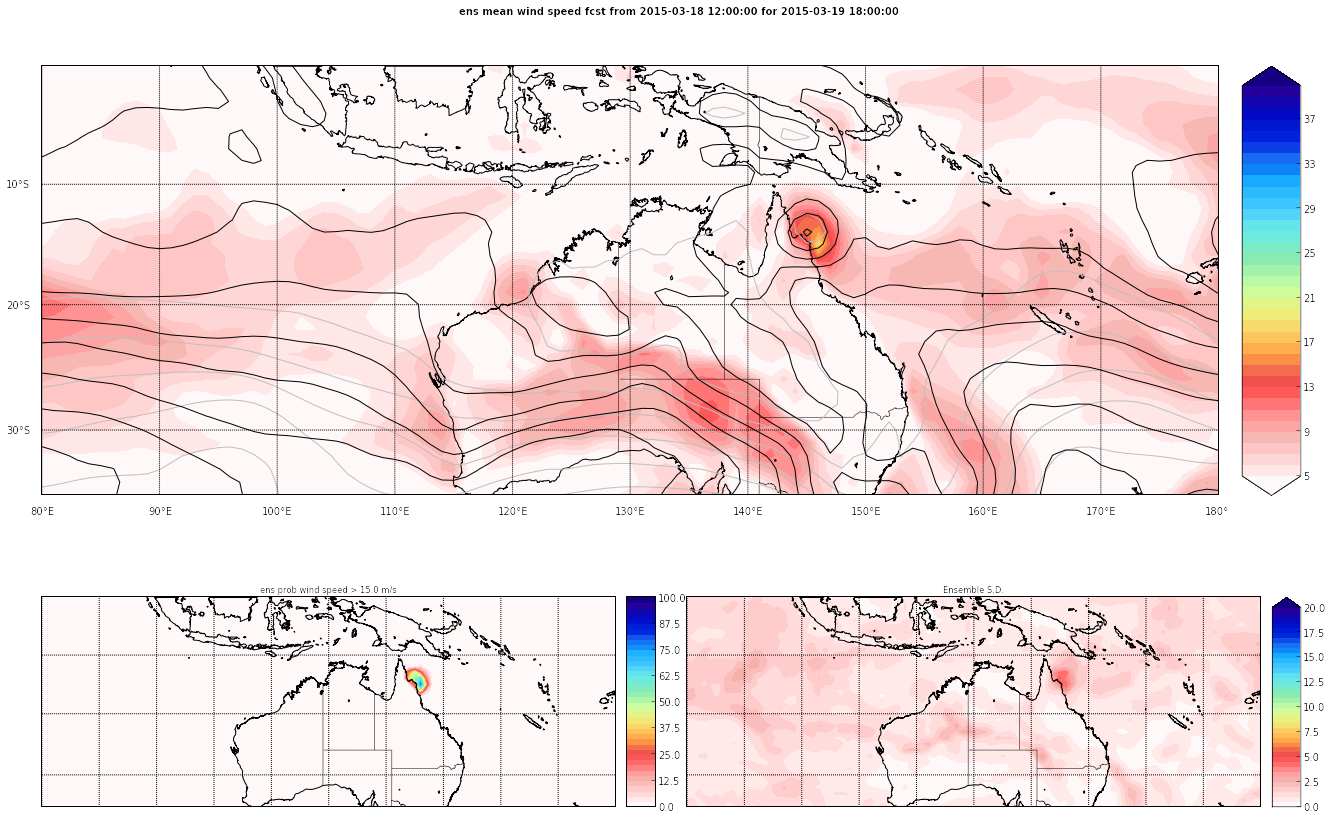

In [10]:
interact(plot_mean_wind, timestamp=widgets.DropdownWidget(values=valid_dates, value=valid_dates[1]),
         threshold=(5.0,25.0, 1.0))

In [11]:
def plot_ensemble_wind(timestamp):
    
    #idx = valid_dates.index(datetime.strptime(timestamp,"%Y%m%d%H"))
    idx = valid_dates.index(timestamp)
    #timestring = valid_dates[idx]
    uu = gfs_fcst.variables['ugrdsig995'][:,idx,:,:]
    vv = gfs_fcst.variables['vgrdsig995'][:,idx,:,:]
    wspdens = np.sqrt(uu*uu + vv*vv)
    prmslens = gfs_fcst.variables['prmslmsl'][:,idx,:,:]
    hgt1000 = gfs_fcst.variables['hgtprs'][:,idx,0,:,:]
    hgt500 = gfs_fcst.variables['hgtprs'][:,idx,12,:,:]
    thkens = (hgt500 - hgt1000)/10.
    wspd = wspdens.mean(axis=0)
    prmsl = prmslens.mean(axis=0)
    thk = thkens.mean(axis=0)

    lats = gfs_fcst.variables['lat'][:]; lons = gfs_fcst.variables['lon'][:]
    lons, lats = np.meshgrid(lons, lats) 
    clevs = np.arange(5., 41.)
    m = Basemap(projection='mill',llcrnrlon=80., llcrnrlat=-45, urcrnrlon=180., urcrnrlat=0.,resolution='i')
    x,y = m(lons, lats)
    fig = plt.figure(figsize=(20,16))
    for nens in range(1,21):
        ax = plt.subplot(5,4,nens)
        m.drawcoastlines()
        cs = m.contourf(x,y, wspdens[nens], clevs, cmap=basemapcm.GMT_haxby_r, extend='both')
        ct = m.contour(x,y, thkens[nens],np.arange(500, 600, 4), colors='0.75', linestyle=':')
        cp = m.contour(x,y,prmslens[nens]/100.,np.arange(900, 1040, 2),colors='k')
        t = plt.title('Member %s' % nens)
    
    fig.suptitle('Ensemble wind speed forecast from %s for %s' % (valid_dates[0],valid_dates[idx]),fontweight='bold')
    plt.tight_layout()

<function __main__.plot_ensemble_wind>

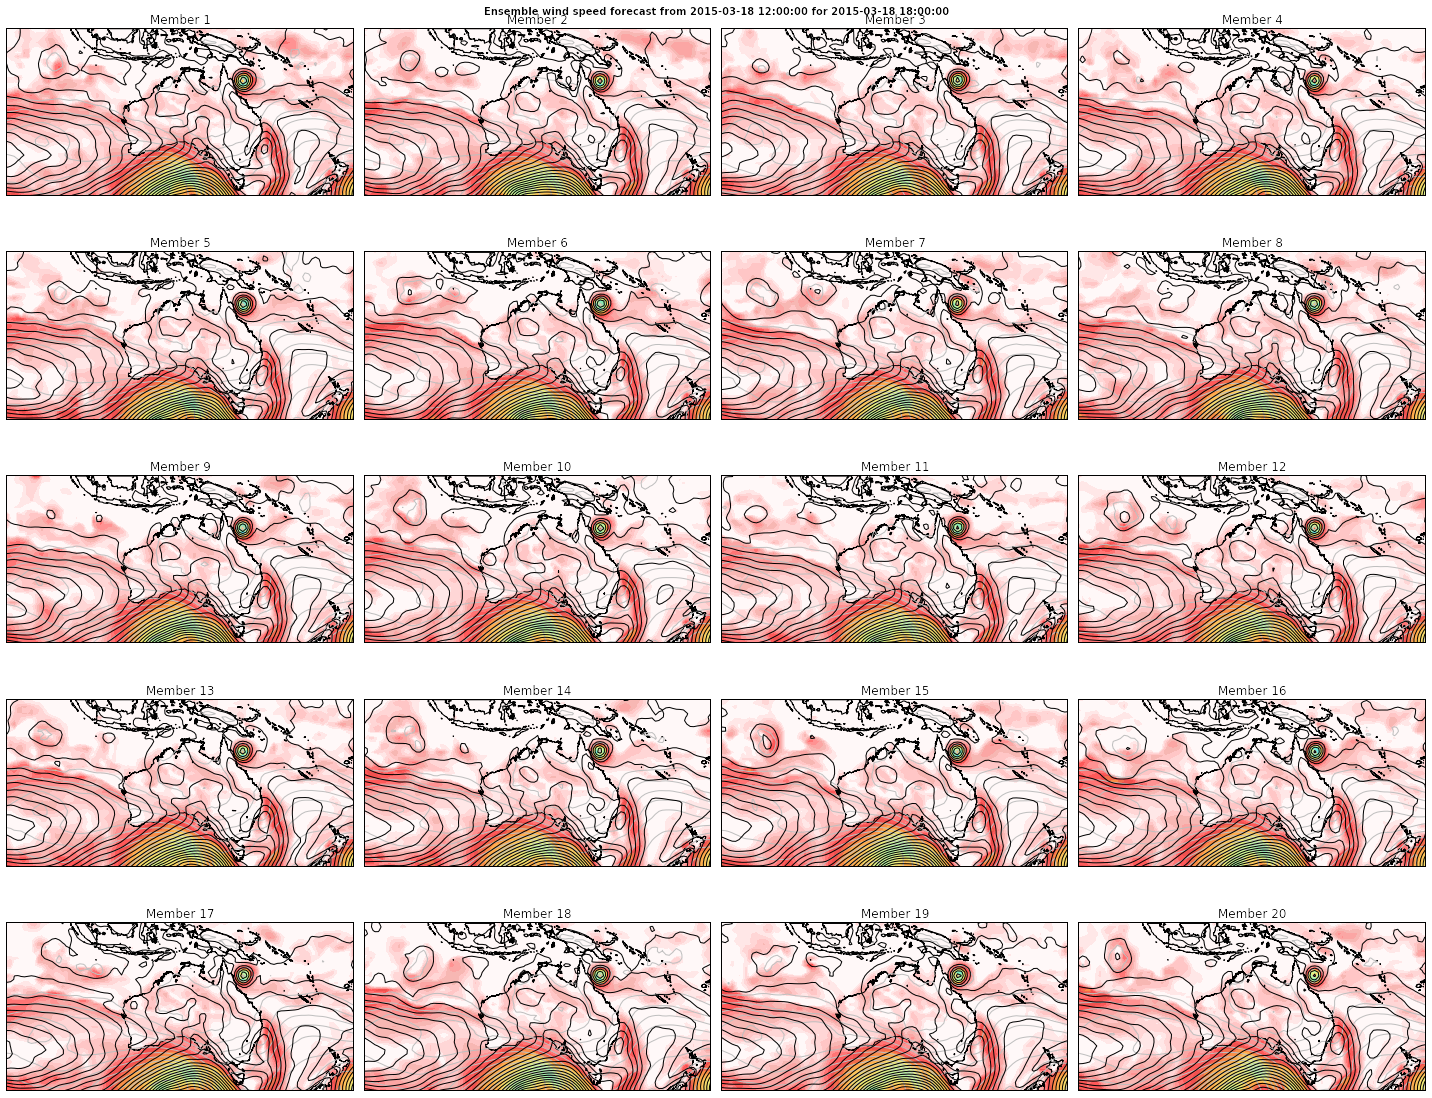

In [12]:
interact(plot_ensemble_wind, timestamp=widgets.DropdownWidget(values=valid_dates, value=valid_dates[1]))